In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

bikes = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes.csv')

In [37]:
!pip install -U tensorflow


In [38]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load data
bikes = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes.csv')

In [7]:
import tensorflow as tf
print(tf.__version__)


2.19.0


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Mean Squared Error (MSE): 3229138.25
Root Mean Squared Error (RMSE): 1796.98
R-squared Score (R²): 0.1000


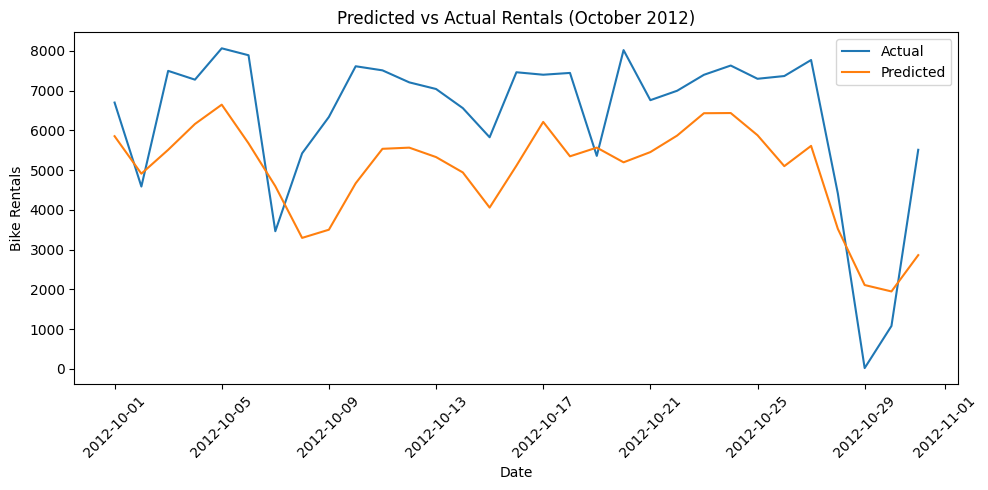

In [39]:


# --- Load and Prepare Data ---
bikes = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes.csv')

# Parse date
bikes['dteday'] = pd.to_datetime(bikes['dteday'])

# Group to daily level
daily = bikes.groupby('dteday').agg({
    'temp_c': 'mean',
    'feels_like_c': 'mean',
    'hum': 'mean',
    'windspeed': 'mean',
    'holiday': 'first',
    'workingday': 'first',
    'season': 'first',
    'weathersit': 'mean',
    'casual': 'sum',
    'registered': 'sum'
}).reset_index()

# Create target variable
daily['count'] = daily['casual'] + daily['registered']

# Time features
daily['day_of_week'] = daily['dteday'].dt.dayofweek
daily['month'] = daily['dteday'].dt.month
daily['is_weekend'] = daily['day_of_week'].isin([5, 6]).astype(int)

# Cyclical encoding
daily['day_sin'] = np.sin(2 * np.pi * daily['day_of_week'] / 7)
daily['day_cos'] = np.cos(2 * np.pi * daily['day_of_week'] / 7)
daily['month_sin'] = np.sin(2 * np.pi * daily['month'] / 12)
daily['month_cos'] = np.cos(2 * np.pi * daily['month'] / 12)

# Lag and rolling features
daily['lag_1'] = daily['count'].shift(1)
daily['lag_7'] = daily['count'].shift(7)
daily['rolling_mean_3'] = daily['count'].rolling(window=3).mean().shift(1)
daily['rolling_mean_7'] = daily['count'].rolling(window=7).mean().shift(1)

daily.dropna(inplace=True)
daily.reset_index(drop=True, inplace=True)

# One-hot encode categorical variables
daily = pd.get_dummies(daily, columns=['season', 'holiday', 'workingday'], drop_first=True)

# --- Separate Modeling for Casual and Registered Users ---
features = [col for col in daily.columns if col not in ['dteday', 'casual', 'registered', 'count']]

train_bikes = daily[daily['dteday'] < '2012-10-01']
test_bikes = daily[(daily['dteday'] >= '2012-10-01') & (daily['dteday'] <= '2012-10-31')]

X_train = train_bikes[features]
X_test = test_bikes[features]

# --- Model for Casual Users ---
scaler_casual = StandardScaler()
X_train_scaled_casual = scaler_casual.fit_transform(X_train)
X_test_scaled_casual = scaler_casual.transform(X_test)

y_train_casual = train_bikes['casual']
y_test_casual = test_bikes['casual']

model_casual = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)
])

model_casual.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_casual.fit(X_train_scaled_casual, y_train_casual, validation_split=0.2, epochs=200, callbacks=[early_stop], verbose=0)

# --- Model for Registered Users ---
scaler_registered = StandardScaler()
X_train_scaled_reg = scaler_registered.fit_transform(X_train)
X_test_scaled_reg = scaler_registered.transform(X_test)

y_train_registered = train_bikes['registered']
y_test_registered = test_bikes['registered']

model_registered = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)
])

model_registered.compile(optimizer='adam', loss='mse')
model_registered.fit(X_train_scaled_reg, y_train_registered, validation_split=0.2, epochs=200, callbacks=[early_stop], verbose=0)

# --- Combined Predictions ---
pred_casual = model_casual.predict(X_test_scaled_casual).flatten()
pred_registered = model_registered.predict(X_test_scaled_reg).flatten()
pred_total = pred_casual + pred_registered

y_true = test_bikes['count']
mse = mean_squared_error(y_true, pred_total)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, pred_total)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared Score (R²): {r2:.4f}")

# --- Save & Plot ---
results = test_bikes[['dteday']].copy()
results['predicted_count'] = pred_total
results['actual_count'] = y_true.values

results.to_csv('bike_predictions_split_model.csv', index=False)

plt.figure(figsize=(10, 5))
plt.plot(results['dteday'], results['actual_count'], label='Actual')
plt.plot(results['dteday'], results['predicted_count'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Bike Rentals')
plt.title('Predicted vs Actual Rentals (October 2012)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Mean Squared Error (MSE): 3737889.00
Root Mean Squared Error (RMSE): 1933.36
R-squared Score (R²): -0.0418


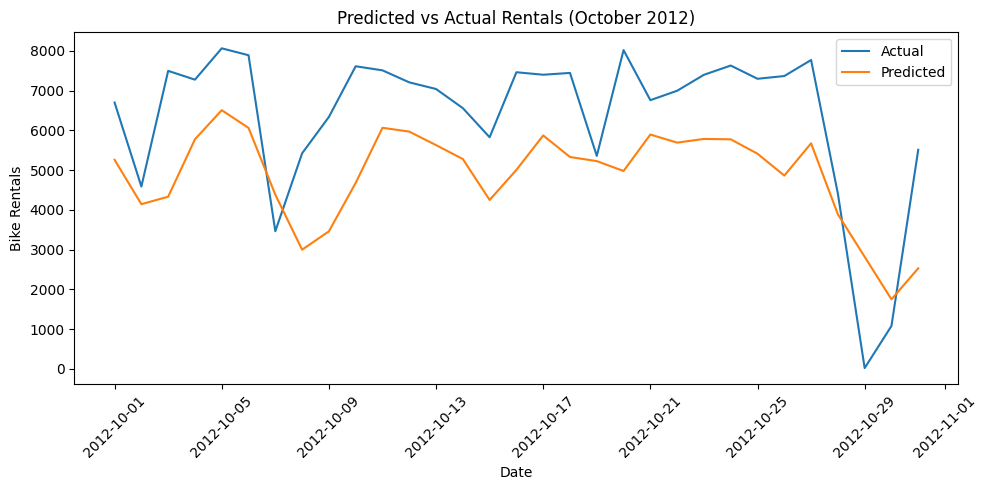

In [21]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate MSE
mse = mean_squared_error(y_test, predictions)

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate R² score
r2 = r2_score(y_test, predictions)

# Print the evaluation metrics
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared Score (R²): {r2:.4f}")


Mean Squared Error (MSE): 8622136.00
Root Mean Squared Error (RMSE): 2936.35
R-squared Score (R²): -1.4032


In [41]:
# Try without Dropout
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)
])
